## Copy Pasted Some Data from FBREF On 4 Liverpool Midfielders

It was messy, it didn't look good. But I mean, how hard could it be to clean it up, turn out, not that easy but not that hard either. 

After loading the sheet names, we can loop through each and essentially combine them all as each sheet had within it 3 tables with "Statistic" as the header. 

In the end, we added a column for each player representing the different sheets and had one mega-dataframe. 

In [55]:
# import it 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.interpolate import make_interp_spline


# load the dataset
file_path = "liv_midfield_scouting_fbref.xlsx"
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names
print("Available sheets:", sheet_names)

Available sheets: ['alexis_mcallister', 'curits_jones', 'ryan_gravenberch', 'dominik_szoboszlai']


In [56]:
# container for cleaned data
all_data = []

# loop through each sheet, join and clean the data
for sheet in sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet, header=None)
    table = df.iloc[header_row+1:, :3].copy()
    table.columns = ['Metric', 'Per90', 'Percentile']
    
    header_idx = df[df.iloc[:, 0] == "Statistic"].index
    if header_idx.empty:
        continue
    header_row = header_idx[0]

    stats_df = df.loc[header_row+1:, [0, 1, 2]]
    stats_df.columns = ['Metric', 'Per90', 'Percentile']

    stats_df = stats_df.dropna(subset=['Metric', 'Per90', 'Percentile'])
    stats_df['Player'] = sheet.strip()

    all_data.append(stats_df)

# concatenate all dataframes
final_df = pd.concat(all_data, ignore_index=True)

# ensure numeric datatypes
final_df['Per90'] = pd.to_numeric(final_df['Per90'], errors='coerce')
final_df['Percentile'] = pd.to_numeric(final_df['Percentile'], errors='coerce')

cols = ['Player', 'Metric', 'Per90', 'Percentile']
final_df = final_df[cols]

final_df.to_csv("cleaned_liverpool_midfield.csv", index=False)

In [57]:
# some rows have nulls, but metric seems odd. Show random sample of null rows then if rows are full null we can remove. 
null_mask = final_df[['Per90', 'Percentile']].isnull().all(axis=1)
only_full_nulls = final_df.isnull().any(axis=1) == null_mask
print("All nulls are fully empty rows:", only_full_nulls.all())
final_df = final_df.dropna(subset=['Per90', 'Percentile'], how='all')

All nulls are fully empty rows: True


In [58]:
final_df.sample(4)
#final_df.info()

,Player,Metric,Per90,Percentile
384,ryan_gravenberch,Red Cards,0.02,18.0
340,curits_jones,Penalty Kicks Conceded,0.00,63.0
583,dominik_szoboszlai,Passes Attempted,46.93,80.0
579,dominik_szoboszlai,Goals - xG,-0.04,25.0


## Comparing Our Midfielders

Instead of running 12 different blocks of code with copy-pasted radar plots, I decided to generate a singular funciton that randomly selects 3 metrics, prints them, then we generate a radar plot of those three metrics. This allows us to quickly cycle through a range of metrics so that we can determine who is excelling where. This function, could work for any number of players, and if the scale was large enough we could loop through the entire premier league, or even the top 5 leagues in europe. 

Explaining the function. 

First we select the random metrics with random. Then we create a new dataframe with only those metrics selected, ensuring to drop duplicates so the function doesn't break. The rest is about creating the radar plot and ensuring it is labelled correctly and plots well. 

In [74]:
def plot_random_midfield_radar(df):
    # Pick 3 random unique metrics
    available_metrics = df['Metric'].unique()
    selected_metrics = random.sample(list(available_metrics), 3)
    print("Selected Metrics:", selected_metrics)

    # Filter data for selected metrics
    radar_df = df[df['Metric'].isin(selected_metrics)].copy()

    # Remove duplicates to avoid errors in plotting
    radar_df = radar_df.drop_duplicates(subset=['Player', 'Metric'])

    # Pivot for radar chart format
    radar_pivot = radar_df.pivot(index='Player', columns='Metric', values='Percentile')
    
    # Ensure all players and metrics are present
    radar_pivot = radar_pivot[selected_metrics]  # enforce column order

    # Radar setup
    labels = selected_metrics
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    # Setup plot with dark background
    plt.style.use('default')  # Light style

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    fig.patch.set_facecolor('#f0f0f0')
    ax.set_facecolor('#f5f5f5')

    # Set radar angles
    angles_base = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)
    angles_full = np.linspace(0, 2 * np.pi, 200)  # for spline

    for player in radar_pivot.index:
        values = radar_pivot.loc[player].tolist()
        values += values[:1]  # close loop

        ax.plot(angles, values, label=player, linewidth=2, marker='o')  # crisp rounded points
        ax.fill(angles, values, alpha=0.1)


    # Formatting
    ax.set_xticks(angles_base)
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_yticklabels(['20', '40', '60', '80', '100'], fontsize=10, color='gray')
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.grid(color='lightgray', linestyle='dotted')
    ax.set_title("Random Attribute Radar Comparison", size=16, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)

    plt.tight_layout()
    plt.show()


Selected Metrics: ['GCA (Live-ball Pass)', 'npxG/Shot', 'Offsides']


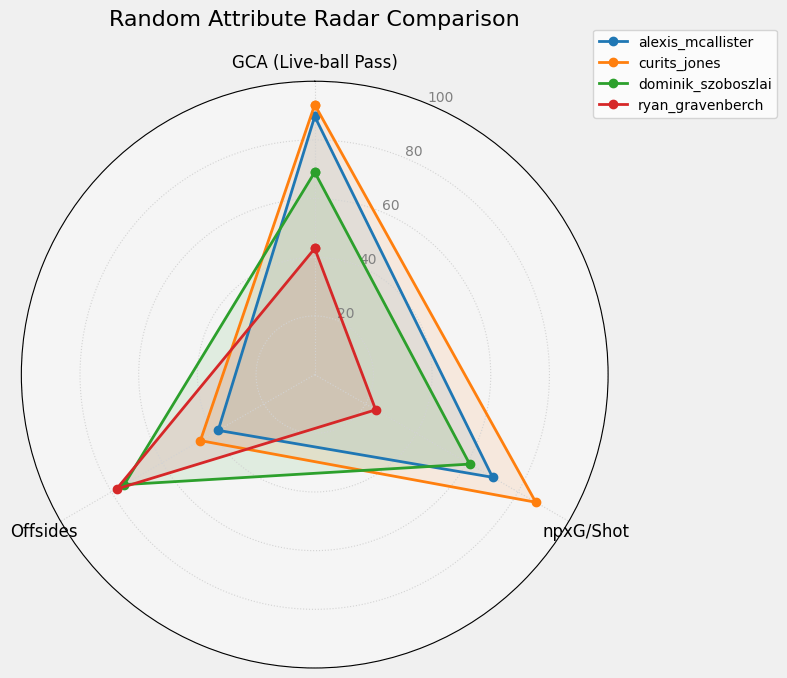

In [76]:
plot_random_midfield_radar(final_df)

## It's Fun To See The Differences

As you can see, as you loop through these graphs you begin to get a feel for where the players excel and where they do not. It's important to not overstate it however, Gravenberch being consistently low on shots/goals is likely due to his playstyle and position, a lot more than his capabilities. 

Next, we're going to try something crazy that in order to work would require a lot more refinement. But we're having fun, so I'm going to run this 1000 times, ranking each players posoition so that at the end we have a leaderboard of metric performance. 

In [77]:
from collections import defaultdict

def simulate_midfield_value(df, n_runs=1000):
    players = df['Player'].unique()
    score_tracker = defaultdict(int)

    for _ in range(n_runs):
        # 1. Pick 3 random metrics
        metrics = random.sample(list(df['Metric'].unique()), 3)

        # 2. Filter data and pivot
        subset = df[df['Metric'].isin(metrics)].drop_duplicates(subset=['Player', 'Metric'])
        pivot = subset.pivot(index='Player', columns='Metric', values='Percentile')

        # Skip run if any player missing a metric
        if pivot.shape[0] != len(players) or pivot.isnull().values.any():
            continue

        # 3. Compute average percentile for each player
        pivot['score'] = pivot.mean(axis=1)

        # 4. Rank and assign points (4 for 1st, 3 for 2nd, ...)
        ranked = pivot['score'].rank(ascending=False, method='min')
        for player, rank in ranked.items():
            score_tracker[player] += int(len(players) - rank + 1)

    # 5. Compile results
    result_df = pd.DataFrame(score_tracker.items(), columns=['Player', 'TotalPoints'])
    result_df['Rank'] = result_df['TotalPoints'].rank(ascending=False, method='min').astype(int)
    return result_df.sort_values('Rank')

In [82]:
results = simulate_midfield_value(final_df, n_runs=10000)

,Player,TotalPoints,Rank
0,alexis_mcallister,28907,1
1,curits_jones,28099,2
2,dominik_szoboszlai,24106,3
3,ryan_gravenberch,19235,4


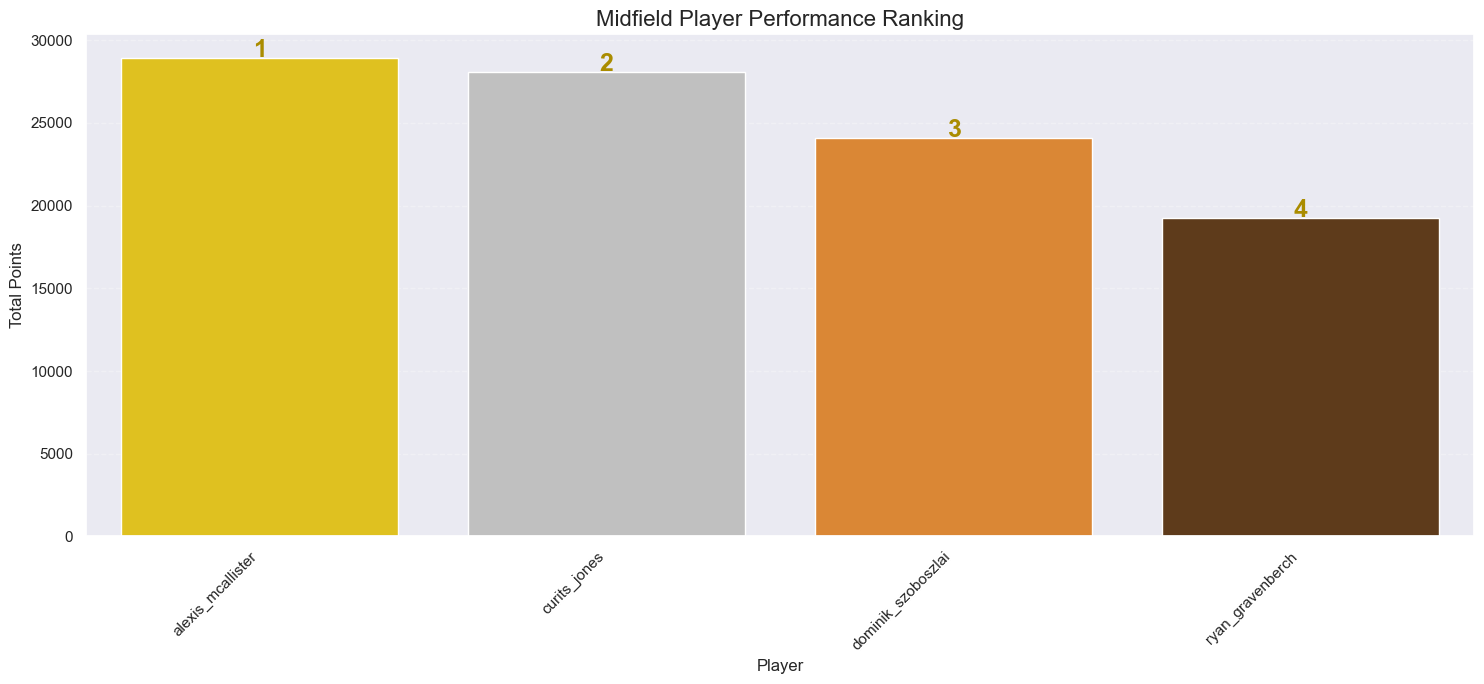

In [119]:
display(results)

# generate a plot of the results
plt.figure(figsize=(15, 7))
sns.set_theme(style="dark")
sorted_results = results.sort_values('TotalPoints', ascending=False)
medal_colors = ['#FFD700', '#C0C0C0', "#F5871A", "#693B10"]  # Gold, Silver, Bronze, Copper
ax = sns.barplot(x='Player', y='TotalPoints', data=sorted_results, palette=medal_colors, hue='Rank')

# Add big numbers above each bar
for i, row in enumerate(sorted_results.itertuples()):
    ax.text(
        i,
        row.TotalPoints + 50,
        f"{row.Rank}",
        ha='center',
        fontsize=18,
        fontweight='bold',
        color='#AA8C00'
    )

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.title('Midfield Player Performance Ranking', fontsize=16)
plt.xlabel('Player')
plt.ylabel('Total Points')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend().remove()
plt.tight_layout()
plt.show()

In [100]:
METRIC_CATEGORIES = {
    "Attacking": [
        "Goals", "Shots", "xG", "Non-Penalty Goals", "Goals/Shot", "xA", "npxG + xAG",
        "Shot-Creating Actions", "Touches (Att 3rd)", "Passes into Final Third"
    ],
    "Possession": [
        "Pass Completion %", "Passes Attempted", "Progressive Passes", "Passes Received",
        "Touches", "Progressive Carries", "Carries", "Through Balls"
    ],
    "Defending": [
        "Tackles", "Blocks", "Interceptions", "Clearances", "Aerials Won", "Tackles Won",
        "Pressures", "Shots Blocked", "Fouls"
    ]
}
def simulate_by_category(df, n_runs=500):
    all_results = []

    for cat, metrics_pool in METRIC_CATEGORIES.items():
        cat_df = df[df['Metric'].isin(metrics_pool)]
        result = simulate_midfield_value(cat_df, n_runs=n_runs)
        result['Category'] = cat
        all_results.append(result)

    return pd.concat(all_results)


In [101]:
def simulate_by_category(df, n_runs=500):
    all_results = []

    for cat, metrics_pool in METRIC_CATEGORIES.items():
        cat_df = df[df['Metric'].isin(metrics_pool)]
        result = simulate_midfield_value(cat_df, n_runs=n_runs)
        result['Category'] = cat
        all_results.append(result)

    return pd.concat(all_results)


In [127]:
category_results = simulate_by_category(final_df, n_runs=500)

In [128]:
pivot = category_results.pivot(index='Player', columns='Category', values='TotalPoints')
pivot['Overall'] = pivot.sum(axis=1)
display(pivot.sort_values('Overall', ascending=False))

Category,Attacking,Defending,Possession,Overall
Player,,,,
alexis_mcallister,1986,1558,810,4354
curits_jones,1514,628,1971,4113
dominik_szoboszlai,1000,1551,852,3403
ryan_gravenberch,500,1263,1375,3138


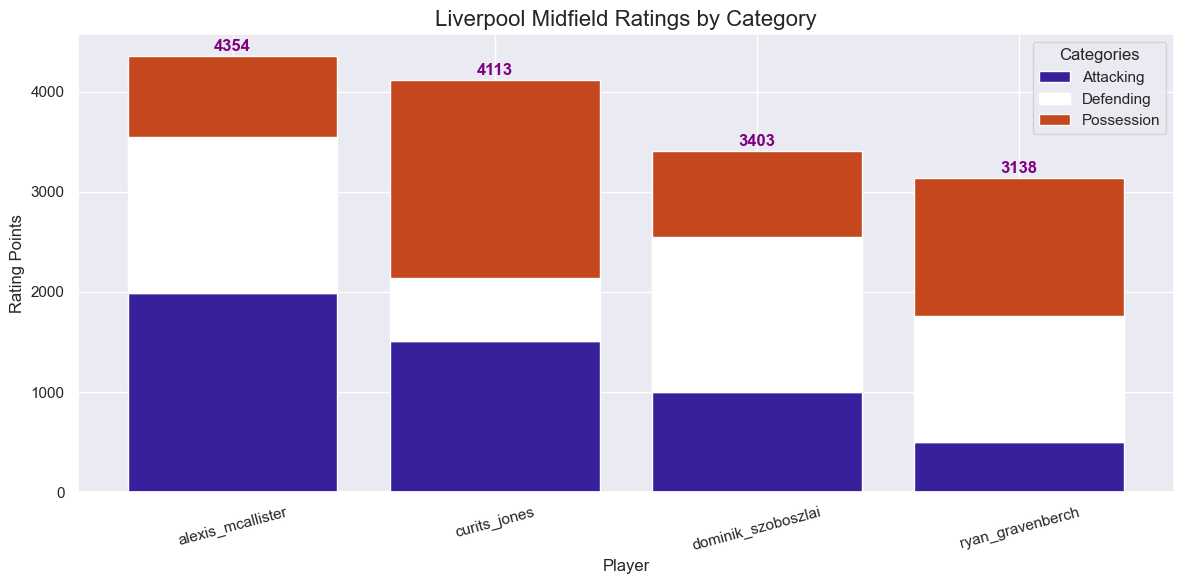

In [130]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(12, 6))

# Create the stacked bars
bottom = 0
colors = ["#38209C", "#FFFFFF", "#C5471E"]  # La France
categories = ['Attacking', 'Defending', 'Possession']

# Sort players by Overall score descending
df = pivot.sort_values('Overall', ascending=False)
df.reset_index(inplace=True)

# Plot each category as a segment of the bar
for i, category in enumerate(categories):
    plt.bar(df['Player'], df[category], bottom=bottom, label=category, color=colors[i])
    bottom += df[category]

# Add overall score text at the top of each bar
for i, row in enumerate(df.itertuples()):
    plt.text(i, row.Overall + 50, f"{row.Overall}", ha='center', fontsize=12, 
             fontweight='bold', color='purple')

# Customize the plot
plt.title('Liverpool Midfield Ratings by Category', fontsize=16)
plt.xlabel('Player')
plt.ylabel('Rating Points')
plt.legend(title='Categories')
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

## Liverpool Midfield Analysis: Player Performance Breakdown

The stacked bar chart provides a clear visualization of how each midfield player's rating is distributed across key performance categories:

- **Alexis Mac Allister** demonstrates remarkable balance across categories, with particularly strong attacking contributions that complement his solid defensive work. His overall profile shows why he's emerged as a complete midfielder at Liverpool.

- **Curtis Jones** reveals a specialist profile with exceptional possession metrics but relatively weaker defensive contributions. This stark contrast helps explain his typical deployment in more advanced midfield roles where his ball retention skills can be maximized.

- **Dominik Szoboszlai** displays a defensive-leaning profile that might surprise some who view him primarily as an attacking midfielder. His relatively lower attacking numbers suggest he's being utilized in a more balanced role than his previous positions.

- **Ryan Gravenberch** shows the most balanced distribution between possession and defensive metrics, though with lower attacking output. This visualization confirms his evolution toward a holding midfield role rather than the box-to-box position he often played in his early career.

The Olympic-style performance ranking in the previous visualization complements this categorical breakdown by providing a clear competitive hierarchy. Together, these visualizations offer both absolute ranking and insight into the playing style and strengths of each midfielder.

## Final Analysis: Implications for Liverpool's Midfield Strategy

Our comprehensive analysis of Liverpool's midfield options reveals several strategic insights that could inform tactical decisions:

1. **Complementary Profiles**: The data clearly shows how each midfielder brings a distinct skill profile, suggesting optimal partnerships based on complementary strengths. Mac Allister's all-around capabilities pair naturally with specialists like Jones (possession) or Szoboszlai (defensive).

2. **Tactical Flexibility**: The varied strengths across the squad enable multiple tactical approaches. Against possession-dominant opponents, a midfield favoring defensive metrics (Mac Allister-Szoboszlai) might be preferable, while matches requiring ball retention could benefit from Jones' inclusion.

3. **Transfer Strategy Implications**: The analysis highlights areas for potential reinforcement in future transfer windows. The relatively lower attacking outputs from Gravenberch and Szoboszlai suggest room for an additional attack-minded midfielder who could provide more goal threat from deeper positions.

4. **Development Pathways**: For younger players like Gravenberch, the data provides a clear development roadmap—specifically improving attacking contributions while maintaining his balanced possession-defense profile.

5. **Match-Specific Selection**: Beyond the overall rankings, the category-specific performance provides a framework for match-specific selection based on opposition analysis. Against counter-attacking teams, defensive specialists might be prioritized, while high-pressing opponents might call for superior possession retention.

This multi-faceted analysis demonstrates how data-driven approaches can complement traditional scouting and tactical analysis, providing objective metrics to inform the subjective art of team selection and strategy. As the season progresses, tracking how these metrics evolve could provide valuable feedback on the effectiveness of coaching interventions and player development.